# Analysis of the effect of Melanin concentration (increased number of photons)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from pymcx import read_output_file, load_mcx_settings
from spectra import blood_mu_a, melanosome_mu_a, water_mu_a

matplotlib.rcParams['figure.figsize'] = (4,4)
matplotlib.rcParams.update({'font.size': 18})

Load the list of parameters run and the files containing the output and settings files. The constant variables are removed for the summary tables.

In [2]:
parameters = pd.read_csv("params.csv", index_col=0)
# Simulations were run for a couple of different melanin concentrations.
parameters.loc[:, parameters.nunique()>1]

,Melanin,Wavelength,OutputFile,SettingsFile
0,0.0001,7.000000e-07,result_0_0_00.mc2,settings_0_0_00.json
1,0.0001,7.100000e-07,result_0_0_01.mc2,settings_0_0_01.json
2,0.0001,7.200000e-07,result_0_0_02.mc2,settings_0_0_02.json
3,0.0001,7.300000e-07,result_0_0_03.mc2,settings_0_0_03.json
4,0.0001,7.400000e-07,result_0_0_04.mc2,settings_0_0_04.json
...,...,...,...,...
121,0.4000,8.600000e-07,result_0_5_16.mc2,settings_0_5_16.json
122,0.4000,8.700000e-07,result_0_5_17.mc2,settings_0_5_17.json
123,0.4000,8.800000e-07,result_0_5_18.mc2,settings_0_5_18.json
124,0.4000,8.900000e-07,result_0_5_19.mc2,settings_0_5_19.json


[(0.9254901960784314, 0.7372549019607844, 0.7058823529411765), (0.8196078431372549, 0.6392156862745098, 0.6431372549019608), (0.7725490196078432, 0.5490196078431373, 0.5215686274509804), (0.6313725490196078, 0.4, 0.3686274509803922), (0.34901960784313724, 0.1843137254901961, 0.16470588235294117), (0.3137254901960784, 0.2, 0.20784313725490197)]


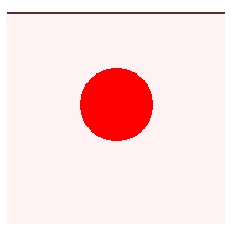

In [3]:
# View the phantom
settings = parameters["SettingsFile"].iloc[0]
volfile = parameters["VolumeFile"].iloc[0]

# Load the phantom settings.
mcx_settings = load_mcx_settings(settings)
dimension = tuple(mcx_settings["Domain"]["Dim"])
volume = np.fromfile(volfile, dtype="uint8").reshape(dimension + (-1,), order="F")

# Visualise the computational phantom.
skin_colours = [(236, 188, 180), (209, 163, 164), (197, 140, 133), (161, 102, 94),(89, 47, 42), (80, 51, 53)]
skin_colours = [tuple(x/255 for x in y) for y in skin_colours]
print(skin_colours)
i = 0
for i in range(5):
    cmap = matplotlib.colors.ListedColormap([(1,1,1), skin_colours[i], (1, 0.95, 0.95), (1,0,0)])
plt.imshow(volume[:, 100, :, 0].T, cmap=cmap)
plt.axis("off")
plt.show()

# Get an array containing the different sections of the phantom, so we can find the spectra across different regions.
volume_numbered = volume[:, 100, :, 0]
# Labels for each region.
regions = ["Outside", "Coupling Layer", "Epidermis", "Background", "Vessel"]

Load the simulated results, convert to a two-dimensional slice.

In [7]:
ms_results = []
# Define in the independent variable which is varied in the experiment.
variable = "Melanin"
labels = parameters[variable].unique()
for dep_variable in labels[:1]:
    selection = parameters[parameters[variable] == dep_variable]
    test = np.zeros((200, 200, 21), order="F")
    for i, (result_file, settings_file) in enumerate(zip(selection["OutputFile"], selection["SettingsFile"])):
        if i>=16:
            continue
        settings = load_mcx_settings(settings_file)
        result = read_output_file(result_file, settings)
        test[:, :, i] = np.sum(result[:, 90:110, :, 0], axis=1)
        # test[:, :, i] = result[:, 100, :, 0]
    ms_results.append(test)

## Total energy absorption over the blood vessel averaged over wavelength

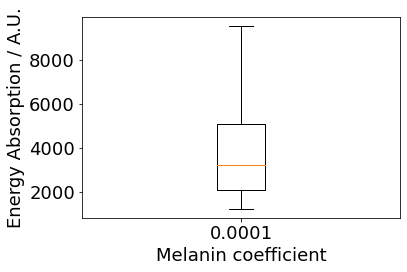

In [9]:
plt.figure(figsize=(6,4))
plt.boxplot([np.mean(s[volume_numbered == 4], axis=1)/1000 for s in ms_results], showfliers=False, labels=labels[:1])
plt.xlabel("Melanin coefficient")
plt.ylabel("Energy Absorption / A.U.")
plt.tight_layout()
plt.savefig("../FiguresOutput/melanin_absorption.png")
plt.show()

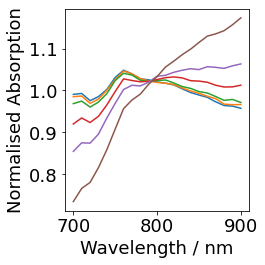

In [7]:
# Calculate the mean absorption spectra over the entire blood vessel over the independent variable.
mean_specs = [np.mean(result[volume_numbered == 4], axis=0) for result in ms_results]

wavelengths = parameters["Wavelength"].unique()
for spec, label in zip(mean_specs, labels):
    plt.plot(1e9*wavelengths, spec/np.mean(spec), label=label)

plt.xlabel("Wavelength / nm")
plt.ylabel("Normalised Absorption")
plt.tight_layout()
plt.savefig("../FiguresOutput/melanin_absorption_spec.png")
plt.show()

# Spectral Unmixing

In [12]:
# Load the basis spectra
wavelengths = parameters["Wavelength"].unique()[:16]
hb = blood_mu_a(wavelengths, 0, water = False)
hbo2 = blood_mu_a(wavelengths, 1, water = False)
water = water_mu_a(wavelengths)
melanin = melanosome_mu_a(wavelengths)
test = np.ones_like(wavelengths)

# Calculate the forward and (pseudo)-inverse matrices
spectra_matrix = np.array([hb, hbo2, water, melanin]).T
inv_matrix = np.linalg.pinv(spectra_matrix)

# Apply the unmixing matrix
unmixed = [np.dot(result[:,:,:16], inv_matrix.T) for result in ms_results]
so2 = [M[:, :, 1]/(M[:, :, 1] + M[:, :, 0]) for M in unmixed]
THb = [M[:, :, 1]+M[:, :, 0] for M in unmixed]

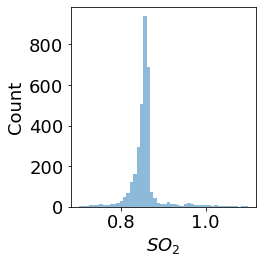

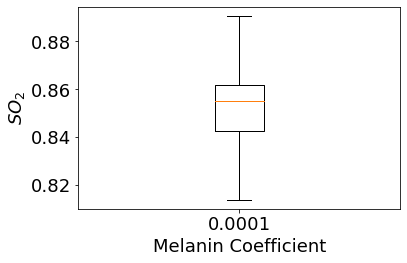

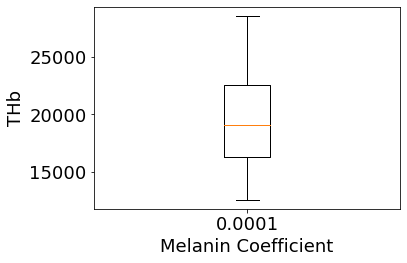

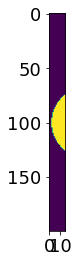

In [18]:
for s, label in zip(so2[:1], labels[:1]):
    plt.hist(s[volume_numbered == 4], bins=50, range=(0.7,1.1), label=label, alpha=0.5)
plt.xlabel("$SO_2$")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../FiguresOutput/melanin_so2_hist.png")
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot([s[volume_numbered == 4] for s in so2[:1]], showfliers=False, labels=labels[:1])
plt.xlabel("Melanin Coefficient")
plt.ylabel("$SO_2$")
plt.tight_layout()
plt.savefig("../FiguresOutput/melanin_so2_box.png")
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot([s[:, 55:70][(volume_numbered == 4)[:, 55:70]] for s in THb[:1]], showfliers=False, labels=labels[:1])
plt.xlabel("Melanin Coefficient")
plt.ylabel("THb")
plt.tight_layout()
plt.savefig("../FiguresOutput/melanin_THb_box.png")
plt.show()
plt.imshow((volume_numbered == 4)[:, 55:70])

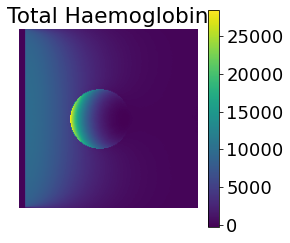

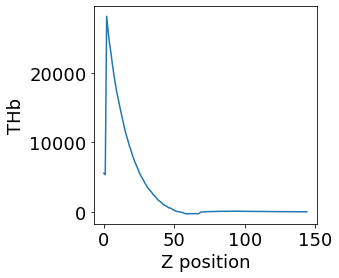

In [19]:
n = 0
plt.imshow(THb[n])
plt.colorbar()
plt.axis("off")
plt.title("Total Haemoglobin")
plt.show()
plt.plot(THb[n][100, 55:])
plt.xlabel("Z position")
plt.ylabel("THb")
plt.show()

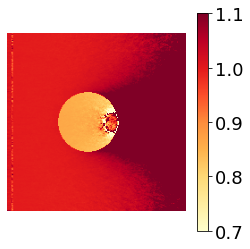

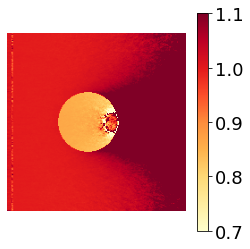

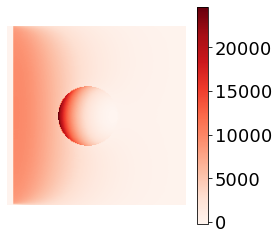

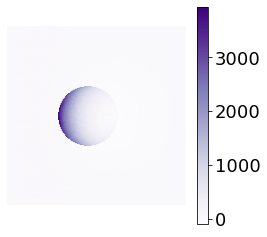

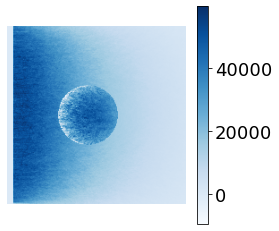

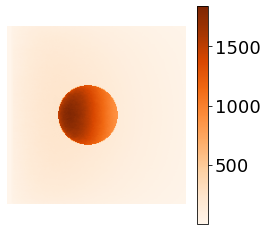

In [20]:
n=-1
# SO2
plt.imshow(so2[n], cmap="YlOrRd", clim=(0.7,1.1))
plt.colorbar()
plt.axis("off")
plt.show()
n=0
# SO2
plt.imshow(so2[n], cmap="YlOrRd", clim=(0.7,1.1))
plt.colorbar()
plt.axis("off")
plt.show()
# HbO2
plt.imshow(unmixed[n][:, :, 1], cmap="Reds")
plt.colorbar()
plt.axis("off")
plt.show()
# Hb
plt.imshow(unmixed[n][:, :, 0], cmap="Purples")
plt.colorbar()
plt.axis("off")
plt.show()
# Water
plt.imshow(unmixed[n][:, :, 2], cmap="Blues")
plt.colorbar()
plt.axis("off")
plt.show()
# Melanin
plt.imshow(unmixed[n][:, :, 3], cmap="Oranges")
plt.colorbar()
plt.axis("off")
plt.show()

In [51]:
! git add ../ --all

The file will have its original line endings in your working directory


In [52]:
! git commit -m "Rotate"

[master 9b75817] Rotate
 2 files changed, 13 insertions(+), 15 deletions(-)
 create mode 100644 FiguresOutput/acoustic_thb.png


In [53]:
! git push origin master

To https://github.com/tre26/SkinPhantomSimulations.git
   6d17537..9b75817  master -> master
